## Importieren

In [ ]:
### importiern von notwendigen Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
### einlesen der Daten von Real 3 und VR 2

data_real3 = pd.read_csv('data_test/2025-11-13-10-07_BA_Project_Real_3.csv', delimiter=';', skiprows = 3)
data_vr2 = pd.read_csv('data_test/2025-11-13-10-26_BA_Project_VR_2.csv', delimiter=';', skiprows = 3)



C:\Users\tills\AppData\Local\Temp\ipykernel_25044\82876672.py:3: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_real3 = pd.read_csv('data_test/2025-11-13-10-07_BA_Project_Real_3.csv', delimiter=';', skiprows = 3)
C:\Users\tills\AppData\Local\Temp\ipykernel_25044\82876672.py:4: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_vr2 = pd.read_csv('data_test/2025-11-13-10-26_BA_Project_VR_2.csv', delimiter=';', skiprows = 3)


In [7]:
### Zeiten Nullen setzen
data_real3['time'] = data_real3['time'] - data_real3['time'][0]
data_vr2['time'] = data_vr2['time'] - data_vr2['time'][0]


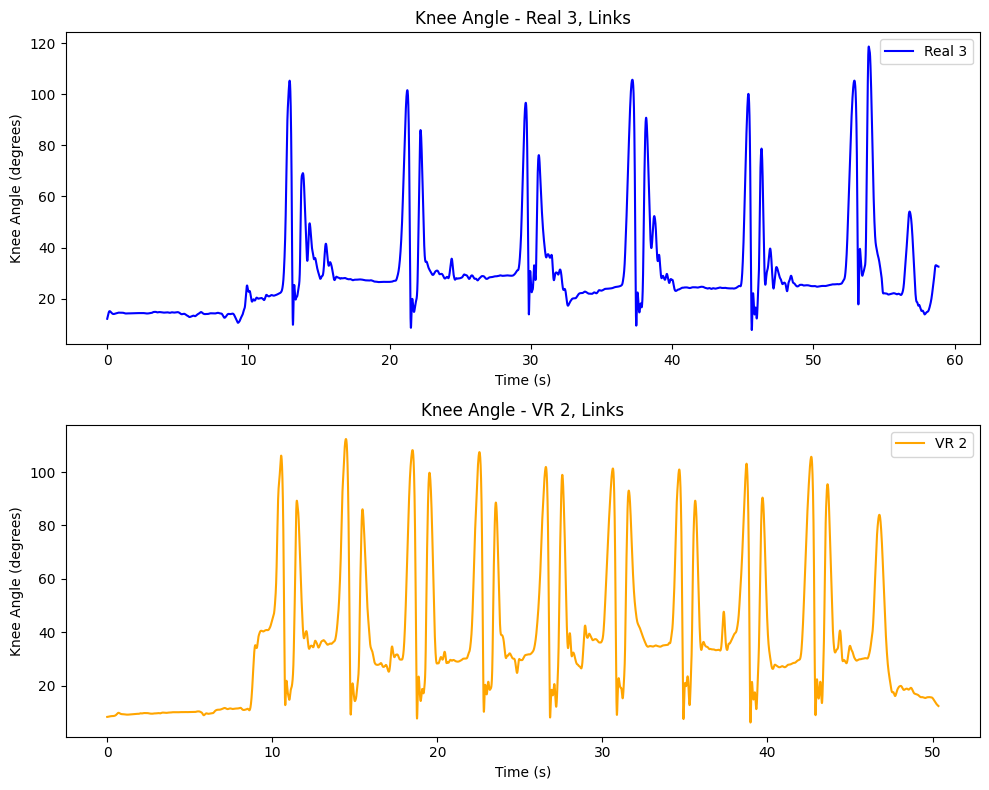

In [8]:
### Plotten des Knie winkel für Real 3 und VR 2 in zwei plots untereinader

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(data_real3['time'], data_real3['LT Knee Flexion (deg)'], label='Real 3', color='blue')
plt.title('Knee Angle - Real 3, Links')
plt.xlabel('Time (s)')
plt.ylabel('Knee Angle (degrees)')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(data_vr2['time'], data_vr2['LT Knee Flexion (deg)'], label='VR 2', color='orange')
plt.title('Knee Angle - VR 2, Links')
plt.xlabel('Time (s)')
plt.ylabel('Knee Angle (degrees)')
plt.legend()
plt.tight_layout()
plt.show()




In [9]:
### Importieren der Zyklendaten für Real 3 und VR 2

cycles = pd.read_csv('cycles_segments_summary.csv', delimiter=';')
print (cycles.head())

   t_start_s  t_end_s   Label  Cycle_ID  Duration_s
0     11.345   16.745  Real 3         1         5.4
1     19.686   25.087  Real 3         2         5.4
2     28.066   33.465  Real 3         3         5.4
3     35.647   41.047  Real 3         4         5.4
4     43.795   49.195  Real 3         5         5.4


In [17]:
# --------------------------
# A. Konfigurations-Einstellungen
# --------------------------

TIME_COL = "time"
N_POINTS = 101 # 0–100 % in 1%-Schritten

# --------------------------
# B. Hilfsfunktion zur Time-Normalisierung (leicht angepasst)
# --------------------------

def time_normalize_kinematics_segment(df, time_col, angle_col, t_start, t_end, n_points=N_POINTS):
    """
    Schneidet df zwischen t_start und t_end und interpoliert
    die Kinematik-Spalte auf n_points → 0–100 % Bewegungszyklus.
    
    Args:
        df (pd.DataFrame): Der gesamte (ge-nullete) Datensatz.
        time_col (str): Name der Zeitspalte.
        angle_col (str): Name der Winkelspalte, die normalisiert werden soll.
        t_start (float): Startzeit des Segments (s).
        t_end (float): Endzeit des Segments (s).
        n_points (int): Anzahl der Punkte für die Normalisierung.
        
    Returns:
        pd.DataFrame: DataFrame mit 'cycle_pct' und der normalisierten Winkelspalte.
    """
    
    # 1. Daten segmentieren
    mask = (df[time_col] >= t_start) & (df[time_col] <= t_end)
    seg = df.loc[mask].copy()

    if seg.shape[0] < 2:
        # Hier geben wir einen leeren DataFrame zurück, um Fehler zu vermeiden.
        return pd.DataFrame() 

    # 2. Zeitraster und Prozent-Vektor erstellen
    t_seg = seg[time_col].to_numpy()
    
    # Sicherstellen, dass die Interpolation funktioniert, indem wir Start und Ende exakt treffen
    t_target = np.linspace(t_seg.min(), t_seg.max(), n_points) 
    cycle_pct = np.linspace(0, 100, n_points)

    # 3. Interpolation
    out = pd.DataFrame({"cycle_pct": cycle_pct})
    y = seg[angle_col].to_numpy()
    
    # Überprüfen, ob das Segment gültige Daten enthält
    if np.isnan(y).all():
        raise ValueError(f"Segment {t_start:.3f}–{t_end:.3f} enthält nur NaN-Werte.")
        
    y_interp = np.interp(t_target, t_seg, y)
    out[angle_col] = y_interp

    return out


# --------------------------
# C. Hauptfunktionen zur Analyse und Visualisierung
# --------------------------

def normalize_kinematics_cycles(data_df, cycle_df, label, angle_col):
    """
    Normalisiert alle Zyklen für eine gegebene Bedingung und einen Winkel.
    
    Args:
        data_df (pd.DataFrame): Der gesamte Rohdatensatz (z.B. data_real3).
        cycle_df (pd.DataFrame): Die Zyklus-Tabelle (mit t_start_s, t_end_s).
        label (str): Der Label der Bedingung ("Real 3" oder "VR 2").
        angle_col (str): Name der Winkelspalte (z.B. "LT Knee Flexion (deg)").
        
    Returns:
        list: Eine Liste von DataFrames, wobei jedes DF ein normalisierter Zyklus ist.
    """
    print(f"\n--- Normalisiere '{angle_col}' für {label} ---")
    
    # Filtern der Zyklus-Tabelle für die aktuelle Bedingung
    segments = cycle_df[cycle_df['Label'] == label].itertuples(index=False)
    
    normalized_cycles = []
    
    for row in segments:
        try:
            cyc = time_normalize_kinematics_segment(
                data_df, 
                TIME_COL, 
                angle_col, 
                row.t_start_s, 
                row.t_end_s, 
                n_points=N_POINTS
            )
            if not cyc.empty:
                normalized_cycles.append(cyc)
        except ValueError as e:
            print(f"  WARNUNG: Zyklus bei {row.t_start_s:.3f}s übersprungen. Grund: {e}")
            
    print(f"  {len(normalized_cycles)} Zyklen erfolgreich normalisiert.")
    return normalized_cycles


def plot_all_cycles_comparison(real_cycles, vr_cycles, angle_col):
    """
    Plottet alle einzelnen Zyklen von Real und VR nebeneinander in einem Figure.
    
    Args:
        real_cycles (list): Liste von DataFrames der normalisierten Real-Zyklen.
        vr_cycles (list): Liste von DataFrames der normalisierten VR-Zyklen.
        angle_col (str): Name der Winkelspalte, die geplottet wird.
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True) # 1 Zeile, 2 Spalten
    
    # Plot für Real-Zyklen (linker Subplot)
    ax_real = axes[0]
    if real_cycles:
        for i, cyc in enumerate(real_cycles, start=1):
            ax_real.plot(cyc["cycle_pct"], cyc[angle_col], 
                         color="blue", alpha=0.3, linewidth=1, 
                         label=f'Zyklus {i}' if i == 1 else "") # Nur einmal Label hinzufügen
        ax_real.set_title(f"Einzelne Zyklen: {angle_col} in Real")
        ax_real.set_ylabel(angle_col)
    else:
        ax_real.set_title(f"Keine Real-Zyklen für {angle_col} gefunden")
    
    ax_real.set_xlabel("Bewegungszyklus [%]")
    ax_real.grid(True, linestyle='--', alpha=0.5)
    # ax_real.legend() # Kann optional hinzugefügt werden, wenn Label gewünscht sind

    # Plot für VR-Zyklen (rechter Subplot)
    ax_vr = axes[1]
    if vr_cycles:
        for i, cyc in enumerate(vr_cycles, start=1):
            ax_vr.plot(cyc["cycle_pct"], cyc[angle_col], 
                       color="orange", alpha=0.3, linewidth=1, 
                       label=f'Zyklus {i}' if i == 1 else "") # Nur einmal Label hinzufügen
        ax_vr.set_title(f"Einzelne Zyklen: {angle_col} in VR")
    else:
        ax_vr.set_title(f"Keine VR-Zyklen für {angle_col} gefunden")
        
    ax_vr.set_xlabel("Bewegungszyklus [%]")
    ax_vr.grid(True, linestyle='--', alpha=0.5)
    # ax_vr.legend() # Kann optional hinzugefügt werden

    plt.suptitle(f"Vergleich der Einzelzyklen für {angle_col}", fontsize=16) # Ein Figure-Titel
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Platz für den Super-Titel schaffen
    plt.show()


def calculate_mean_std(cycles_list, angle_col):
    """Berechnet Mittelwert und Standardabweichung aus einer Liste normalisierter Zyklen."""
    if not cycles_list:
        return None, None
        
    # Kombiniere alle Zyklen zu einem DataFrame
    all_data = pd.concat([cyc[angle_col] for cyc in cycles_list], axis=1)
    
    # Berechne Mittelwert und Standardabweichung für jeden Zeitpunkt (Zeile)
    mean_curve = all_data.mean(axis=1)
    std_curve = all_data.std(axis=1)
    
    return mean_curve, std_curve


def plot_mean_std_comparison(real_cycles, vr_cycles, angle_col):
    """
    Berechnet und plottet Mittelwert und SD beider Bedingungen 
    (Real und VR) in einem gemeinsamen Diagramm.
    """
    
    # 1. Daten berechnen
    mean_real, std_real = calculate_mean_std(real_cycles, angle_col)
    mean_vr, std_vr = calculate_mean_std(vr_cycles, angle_col)
    
    # Prüfen, ob Daten vorhanden sind
    if mean_real is None and mean_vr is None:
        print("Keine Zyklen in beiden Bedingungen für den Vergleich vorhanden.")
        return

    plt.figure(figsize=(10, 6))
    
    # Die x-Achse ist der Prozentsatz des Zyklus (0-100)
    cycle_pct = np.linspace(0, 100, N_POINTS)

    # 2. Plot Real (Blau)
    if mean_real is not None:
        plt.fill_between(cycle_pct, 
                         mean_real - std_real, 
                         mean_real + std_real, 
                         color='blue', alpha=0.2, label='Real $\\pm$ 1 SD')
        plt.plot(cycle_pct, mean_real, color='blue', linewidth=2, label='Real Mittelwert')

    # 3. Plot VR (Orange)
    if mean_vr is not None:
        plt.fill_between(cycle_pct, 
                         mean_vr - std_vr, 
                         mean_vr + std_vr, 
                         color='orange', alpha=0.2, label='VR $\\pm$ 1 SD')
        plt.plot(cycle_pct, mean_vr, color='orange', linewidth=2, label='VR Mittelwert')

    plt.title(f"Vergleich: Mittelwert & Streuung von {angle_col}")
    plt.xlabel("Bewegungszyklus [%]")
    plt.ylabel(angle_col)
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

## Knie Flexion


--- Normalisiere 'RT Knee Flexion (deg)' für Real 3 ---
  6 Zyklen erfolgreich normalisiert.

--- Normalisiere 'RT Knee Flexion (deg)' für VR 2 ---
  9 Zyklen erfolgreich normalisiert.

--- Normalisiere 'LT Knee Flexion (deg)' für Real 3 ---
  6 Zyklen erfolgreich normalisiert.

--- Normalisiere 'LT Knee Flexion (deg)' für VR 2 ---
  9 Zyklen erfolgreich normalisiert.


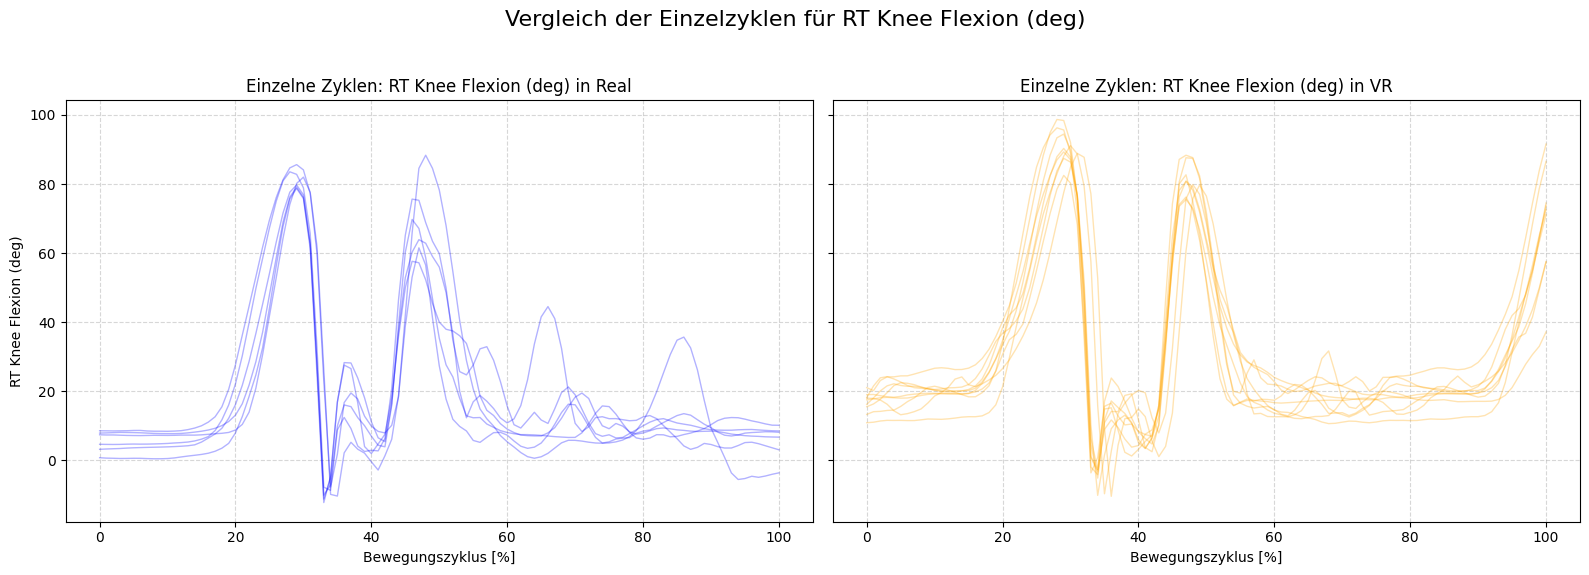

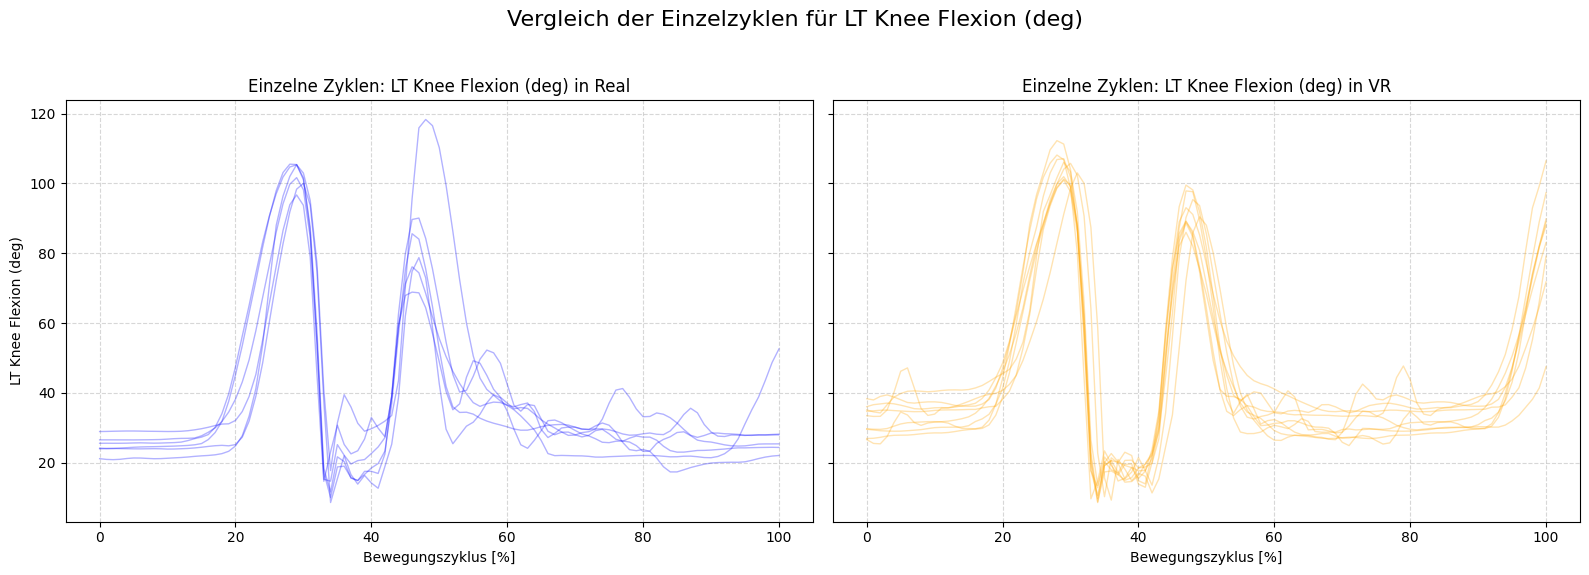

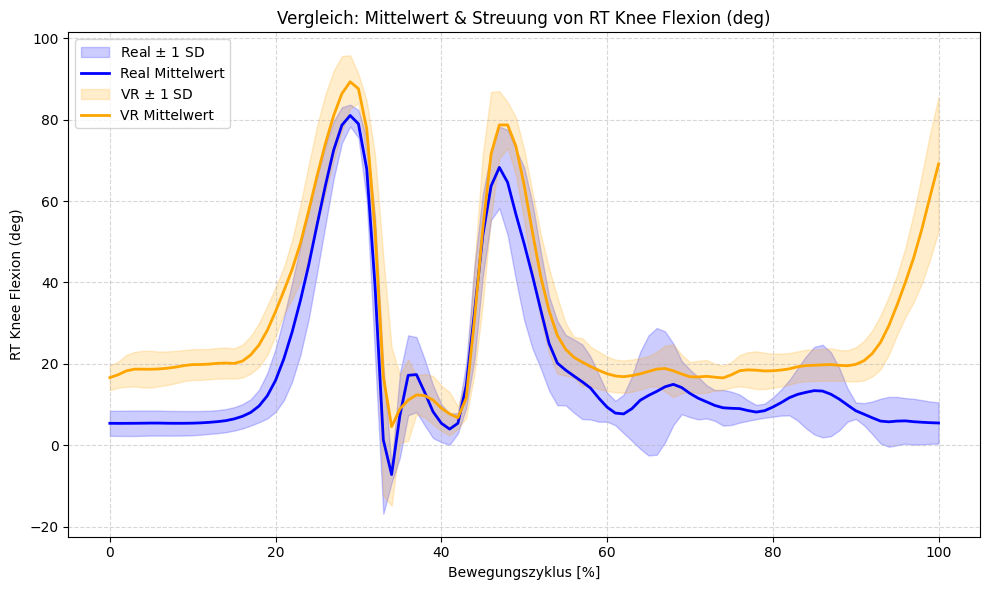

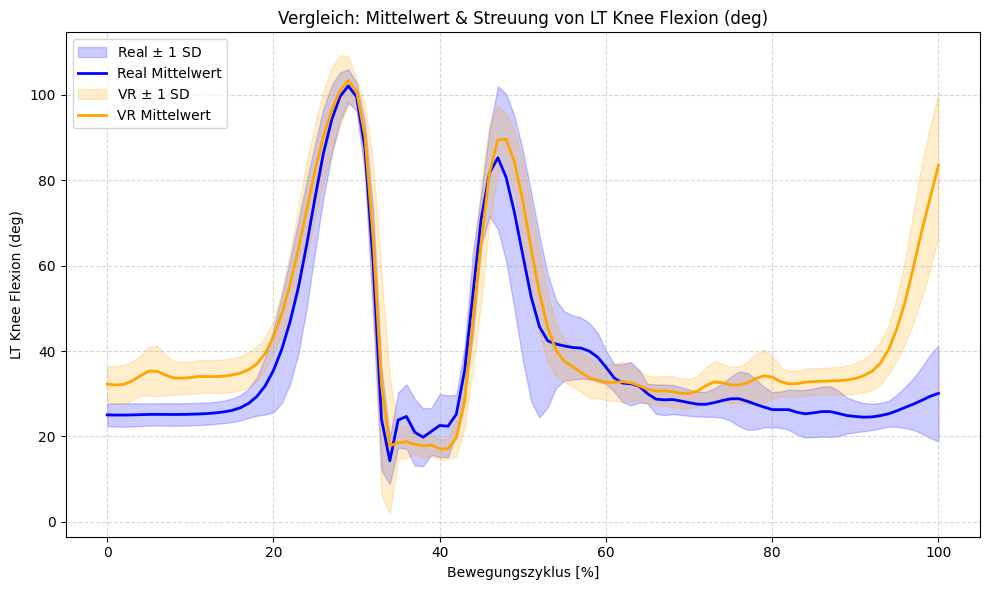

In [23]:
# 1. Normalisierung der Zyklen für beide Bedingungen (muss zuerst laufen!)
# Rechts Knie Flexion
real3_kin_cycles_right = normalize_kinematics_cycles(data_real3, cycles, "Real 3", "RT Knee Flexion (deg)")
vr2_kin_cycles_right = normalize_kinematics_cycles(data_vr2, cycles, "VR 2", "RT Knee Flexion (deg)")
# Links Knie Flexion
real3_kin_cycles_left = normalize_kinematics_cycles(data_real3, cycles, "Real 3", "LT Knee Flexion (deg)")
vr2_kin_cycles_left = normalize_kinematics_cycles(data_vr2, cycles, "VR 2", "LT Knee Flexion (deg)")


# 2. Visualisierung: Einzelne Zyklen nebeneinander (Der gewünschte Plot)
# print("\n--- Plotting Einzelzyklen Vergleich ---")
# HINWEIS: Hier müssen die Variablen real3_kin_cycles und vr2_kin_cycles
# aus dem Normalisierungsschritt gefüllt sein.
plot_all_cycles_comparison(real3_kin_cycles_right, vr2_kin_cycles_right, "RT Knee Flexion (deg)")
plot_all_cycles_comparison(real3_kin_cycles_left, vr2_kin_cycles_left, "LT Knee Flexion (deg)")


# 3. Visualisierung: Mittelwert & SD im Vergleich (Der gewünschte Plot)
# print("\n--- Plotting Mittelwert & SD Vergleich ---")
# HINWEIS: Hier müssen die Variablen real3_kin_cycles und vr2_kin_cycles
# aus dem Normalisierungsschritt gefüllt sein.
plot_mean_std_comparison(real3_kin_cycles_right, vr2_kin_cycles_right, "RT Knee Flexion (deg)")
plot_mean_std_comparison(real3_kin_cycles_left, vr2_kin_cycles_left, "LT Knee Flexion (deg)")

## Fußgelenk Dorsalextension


--- Normalisiere 'RT Ankle Dorsiflexion (deg)' für Real 3 ---
  6 Zyklen erfolgreich normalisiert.

--- Normalisiere 'RT Ankle Dorsiflexion (deg)' für VR 2 ---
  9 Zyklen erfolgreich normalisiert.

--- Normalisiere 'LT Ankle Dorsiflexion (deg)' für Real 3 ---
  6 Zyklen erfolgreich normalisiert.

--- Normalisiere 'LT Ankle Dorsiflexion (deg)' für VR 2 ---
  9 Zyklen erfolgreich normalisiert.


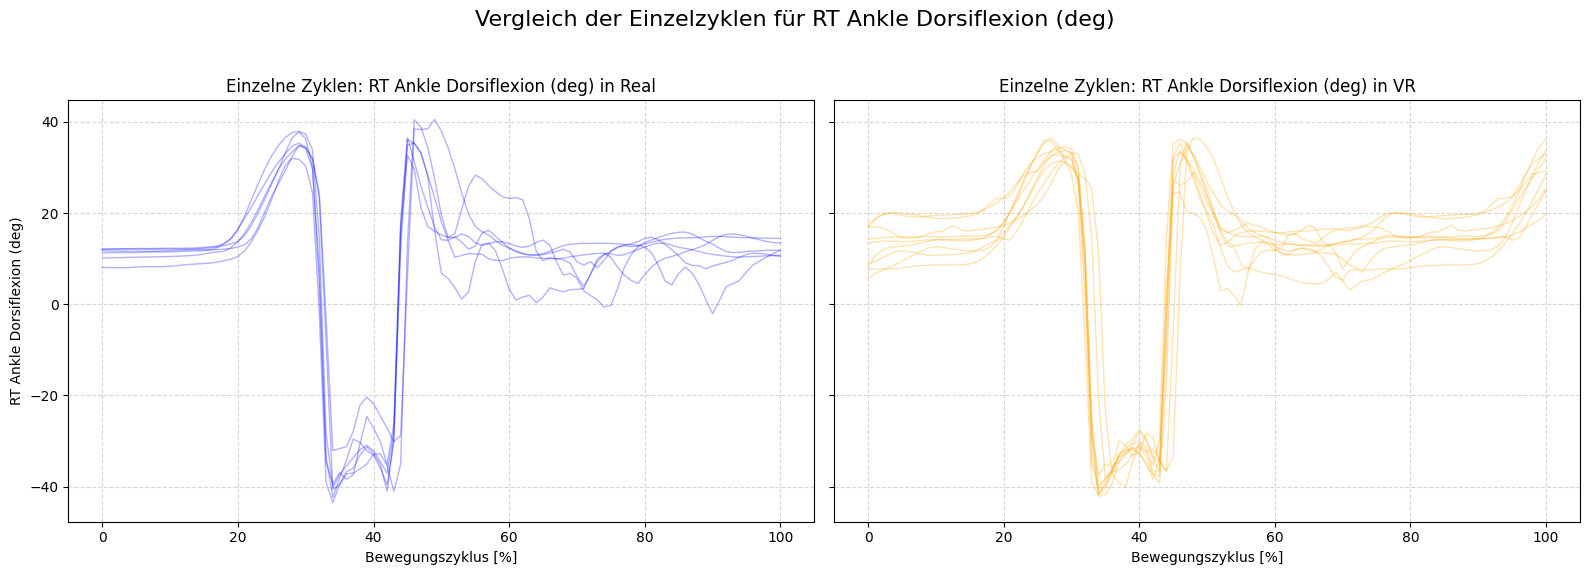

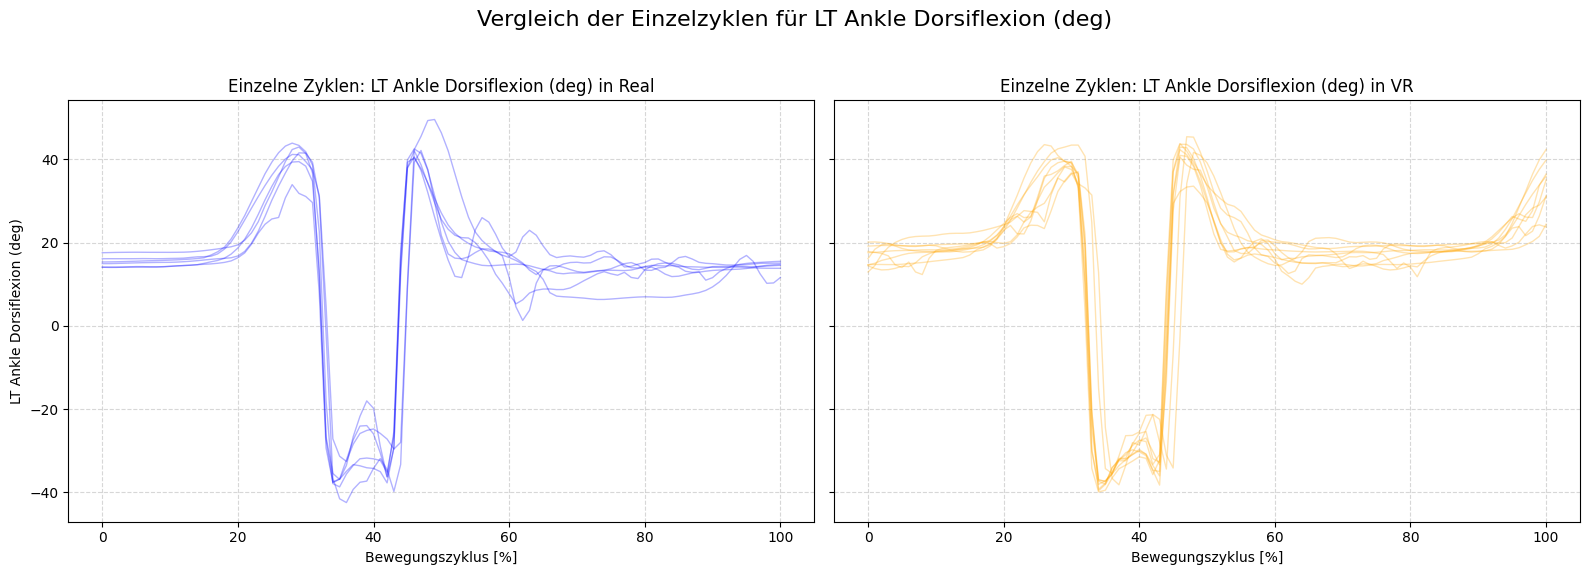

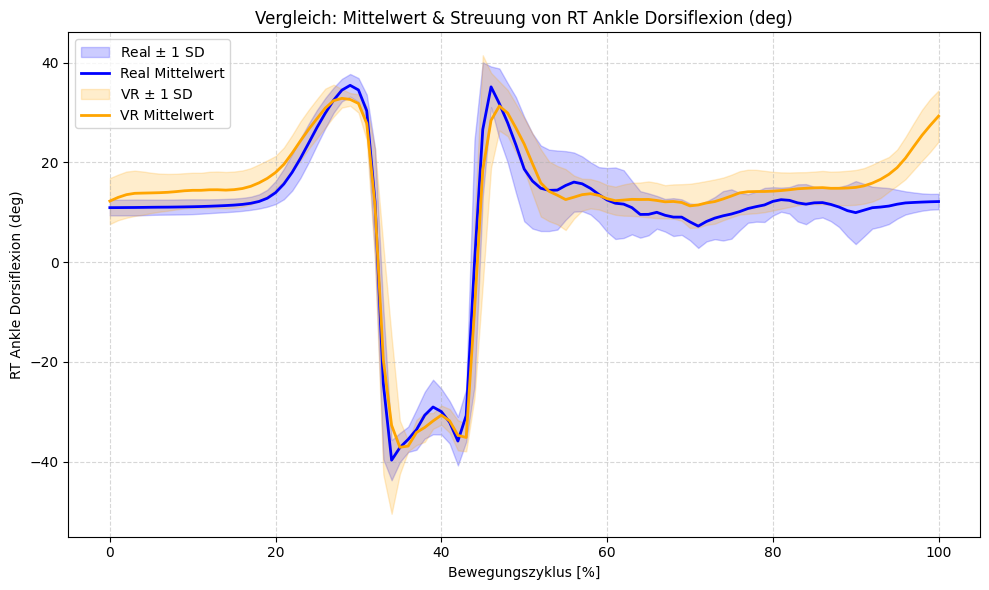

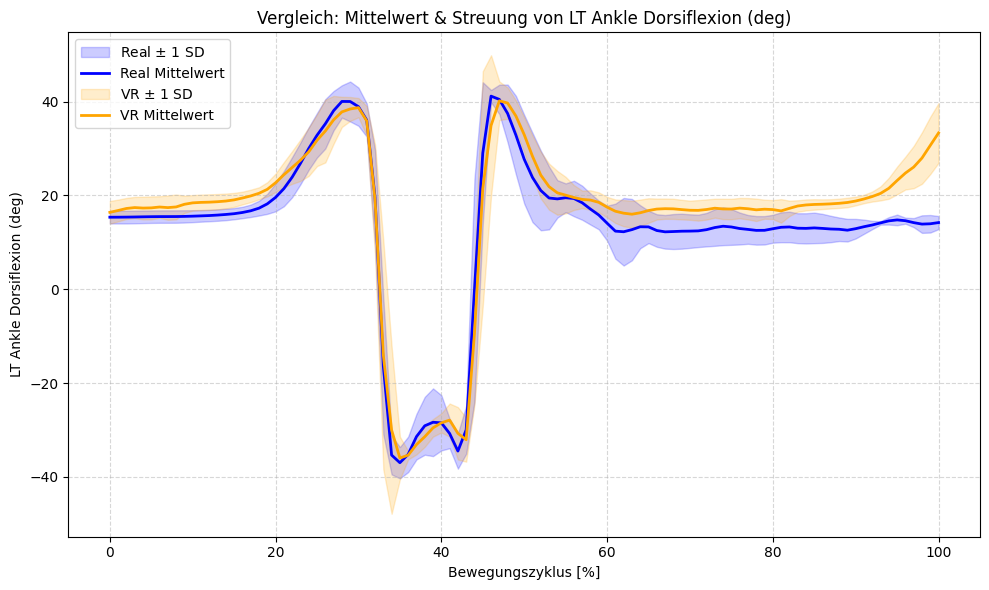

In [24]:
# 1. Normalisierung der Zyklen für beide Bedingungen (muss zuerst laufen!)
# Rechts Knie Flexion
real3_kin_cycles_right = normalize_kinematics_cycles(data_real3, cycles, "Real 3", "RT Ankle Dorsiflexion (deg)")
vr2_kin_cycles_right = normalize_kinematics_cycles(data_vr2, cycles, "VR 2", "RT Ankle Dorsiflexion (deg)")
# Links Knie Flexion
real3_kin_cycles_left = normalize_kinematics_cycles(data_real3, cycles, "Real 3", "LT Ankle Dorsiflexion (deg)")
vr2_kin_cycles_left = normalize_kinematics_cycles(data_vr2, cycles, "VR 2", "LT Ankle Dorsiflexion (deg)")


# 2. Visualisierung: Einzelne Zyklen nebeneinander (Der gewünschte Plot)
# print("\n--- Plotting Einzelzyklen Vergleich ---")
# HINWEIS: Hier müssen die Variablen real3_kin_cycles und vr2_kin_cycles
# aus dem Normalisierungsschritt gefüllt sein.
plot_all_cycles_comparison(real3_kin_cycles_right, vr2_kin_cycles_right, "RT Ankle Dorsiflexion (deg)")
plot_all_cycles_comparison(real3_kin_cycles_left, vr2_kin_cycles_left, "LT Ankle Dorsiflexion (deg)")


# 3. Visualisierung: Mittelwert & SD im Vergleich (Der gewünschte Plot)
# print("\n--- Plotting Mittelwert & SD Vergleich ---")
# HINWEIS: Hier müssen die Variablen real3_kin_cycles und vr2_kin_cycles
# aus dem Normalisierungsschritt gefüllt sein.
plot_mean_std_comparison(real3_kin_cycles_right, vr2_kin_cycles_right, "RT Ankle Dorsiflexion (deg)")
plot_mean_std_comparison(real3_kin_cycles_left, vr2_kin_cycles_left, "LT Ankle Dorsiflexion (deg)")

## Hüft Flexion


--- Normalisiere 'RT Hip Flexion (deg)' für Real 3 ---
  6 Zyklen erfolgreich normalisiert.

--- Normalisiere 'RT Hip Flexion (deg)' für VR 2 ---
  9 Zyklen erfolgreich normalisiert.

--- Normalisiere 'LT Hip Flexion (deg)' für Real 3 ---
  6 Zyklen erfolgreich normalisiert.

--- Normalisiere 'LT Hip Flexion (deg)' für VR 2 ---
  9 Zyklen erfolgreich normalisiert.


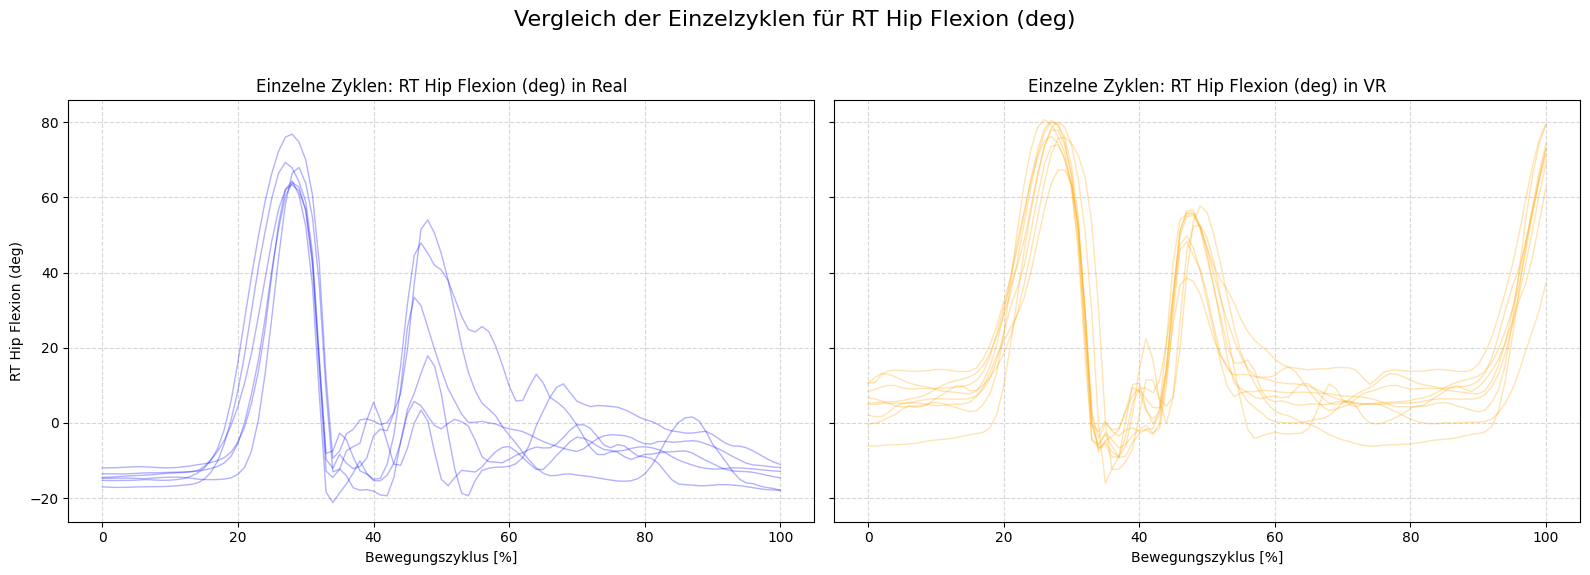

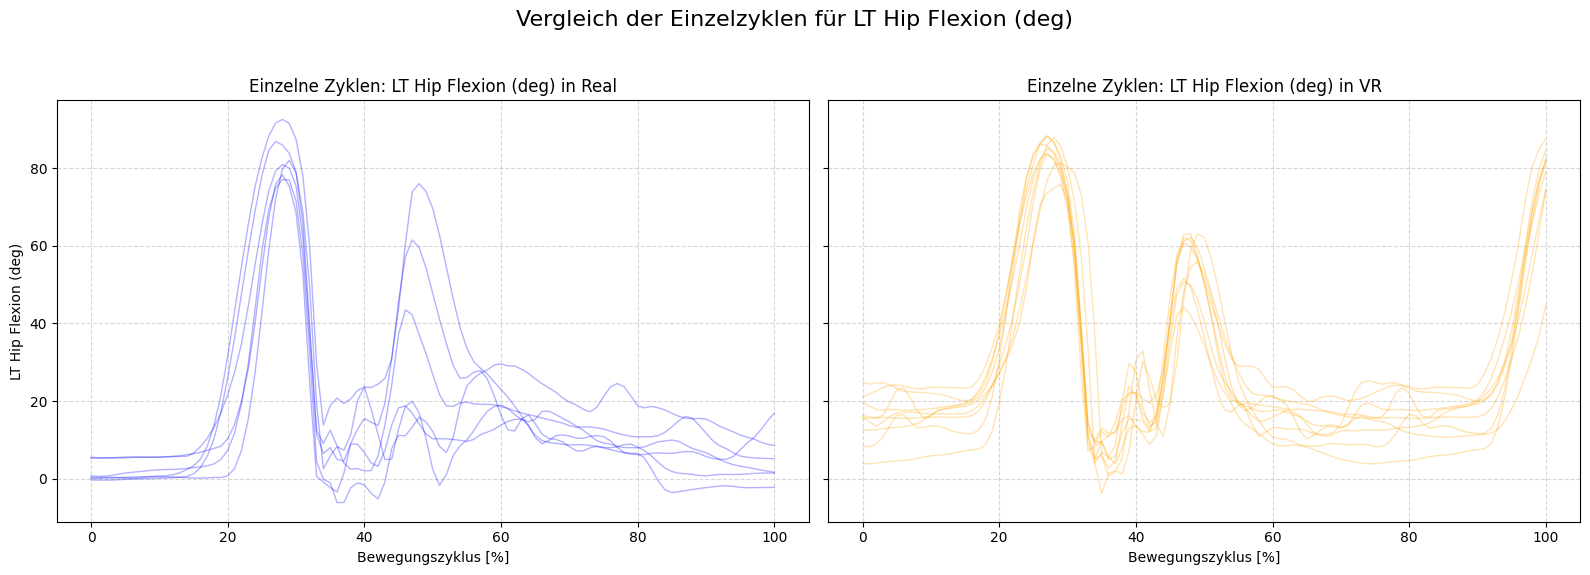

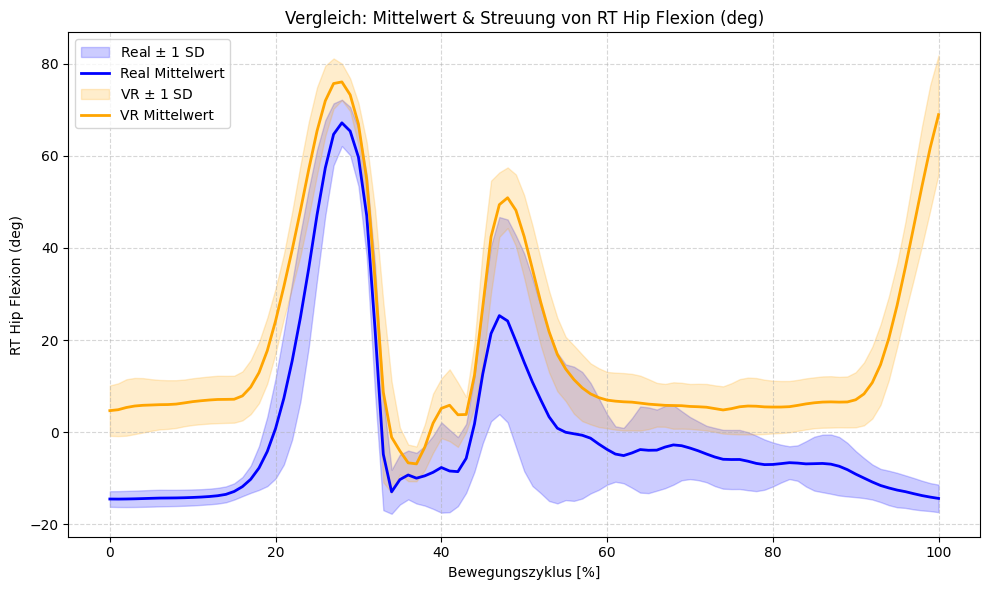

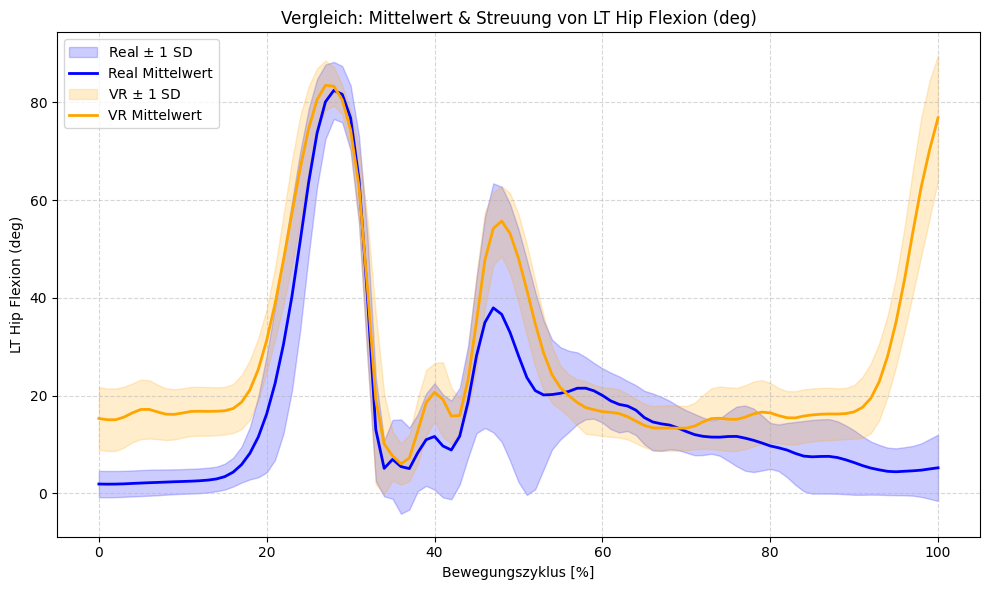

In [25]:
# 1. Normalisierung der Zyklen für beide Bedingungen (muss zuerst laufen!)
# Rechts Knie Flexion
real3_kin_cycles_right = normalize_kinematics_cycles(data_real3, cycles, "Real 3", "RT Hip Flexion (deg)")
vr2_kin_cycles_right = normalize_kinematics_cycles(data_vr2, cycles, "VR 2", "RT Hip Flexion (deg)")
# Links Knie Flexion
real3_kin_cycles_left = normalize_kinematics_cycles(data_real3, cycles, "Real 3", "LT Hip Flexion (deg)")
vr2_kin_cycles_left = normalize_kinematics_cycles(data_vr2, cycles, "VR 2", "LT Hip Flexion (deg)")

# 2. Visualisierung: Einzelne Zyklen nebeneinander (Der gewünschte Plot)
# print("\n--- Plotting Einzelzyklen Vergleich ---")
# HINWEIS: Hier müssen die Variablen real3_kin_cycles und vr2_kin_cycles
# aus dem Normalisierungsschritt gefüllt sein.
plot_all_cycles_comparison(real3_kin_cycles_right, vr2_kin_cycles_right, "RT Hip Flexion (deg)")
plot_all_cycles_comparison(real3_kin_cycles_left, vr2_kin_cycles_left, "LT Hip Flexion (deg)")


# 3. Visualisierung: Mittelwert & SD im Vergleich (Der gewünschte Plot)
# print("\n--- Plotting Mittelwert & SD Vergleich ---")
# HINWEIS: Hier müssen die Variablen real3_kin_cycles und vr2_kin_cycles
# aus dem Normalisierungsschritt gefüllt sein.
plot_mean_std_comparison(real3_kin_cycles_right, vr2_kin_cycles_right, "RT Hip Flexion (deg)")
plot_mean_std_comparison(real3_kin_cycles_left, vr2_kin_cycles_left, "LT Hip Flexion (deg)")